# Using reinforcement learning for combining search methods

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap

# import loss function
from black_it.loss_functions.msm import MethodOfMomentsLoss

# import search methods
from black_it.samplers.halton import HaltonSampler
from black_it.samplers.best_batch import BestBatchSampler
from black_it.samplers.random_forest import RandomForestSampler
from black_it.samplers.xgboost import XGBoostSampler

# import RL classes
from black_it.schedulers.rl.rl_scheduler import RLScheduler
from black_it.schedulers.rl.agents.epsilon_greedy import MABEpsilonGreedy
from black_it.schedulers.rl.envs.mab import MABCalibrationEnv

# import Calibrator class
from black_it.calibrator import Calibrator

In [33]:
# define a simple BH4 model as in Dyer et al. (2022)
def BH4(theta, N, seed):
    """
    Model from Brock and Hommes 1998.
    
    Eqs. (36-40) of Dyer et al., Black-box Bayesian inference for economic agent-based models (2022)
    
    Args:
        theta: parameters
        N: length of simulation
        seed: random seed

    Returns:
        simulated series
    """
    np.random.seed(seed=seed)

    R = 1.0
    sigma = 0.04
    
    beta = 120 # suggested values: 10, 120
    g1, b1, b4 = 0., 0., 0.
    g4 = 1.01
    
    g2, b2, g3, b3 = theta[0], theta[1], theta[2], theta[3]
    # parameter set1: (g2, b2, g3, b3) = (0.9, 0.2, 0.9, −0.2)
    x_lag3 = 0.10
    x_lag2 = 0.10
    x_lag1 = 0.10

    x = np.zeros(N + 2)
    n = np.full(2, 0.50)

    x[0],x[1],x[2] = x_lag1, x_lag2, x_lag3

    g = np.array([g1, g2, g3, g4])
    b = np.array([b1, b2, b3, b4])
    
    for t in range(3, N + 1):
        den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
        
        f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R 
        
        x[t+1] = np.random.normal(f, sigma/R)
        
    return np.atleast_2d(x[2:]).T


Text(0, 0.5, 'y(t)')

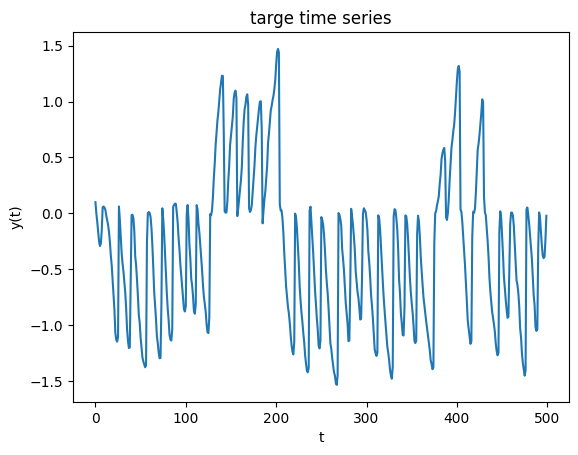

In [34]:
# generate synthetic target series (parameter set 1 of [Dyer et al. (2022)])
target_params = [0.9, 0.2, 0.9, -0.2]
target_series = BH4(theta = target_params, N= 500, seed=0)
plt.plot(target_series)
plt.title("targe time series")
plt.xlabel("t")
plt.ylabel("y(t)")

In [35]:
# define a method-of-moments loss function
loss = MethodOfMomentsLoss()

# define some bounds and precisions on the parameters
bounds = [[0.0, 0.0, 0.0, -1.0], 
          [1.0, 1.0, 1.0, 0.0]]
precisions = [0.01, 0.01, 0.01, 0.01]

In [36]:
# define a MAB learning agent and a MAB environment
alpha, eps = 0.1, 0.1
agent = MABEpsilonGreedy(alpha=alpha, eps=eps, initial_values=0.05, n_actions = 3)
env = MABCalibrationEnv(nb_samplers=3)


In [37]:
# define a set of samplers, and pass them to a reinforcement learning scheduler
best_batch = BestBatchSampler(1)
random_forest = RandomForestSampler(1)
xg_boost = XGBoostSampler(1)

rl_scheduler = RLScheduler(agent=agent, env=env, samplers = [random_forest, xg_boost, best_batch])


In [38]:
# initialise a calibrator object
cal = Calibrator(
    scheduler=rl_scheduler,
    loss_function=loss,
    model=BH4,
    parameters_bounds=bounds,
    sim_length = 500,   # simulation length for each parameter combination
    ensemble_size = 1,     # number of repetitions for each parameter combination
    parameters_precision=precisions,
    real_data=target_series,
    random_state=0,
    n_jobs = 1
)


***
Number of free params:       4.
Explorable param space size: 104060401.
***

Selecting 1 processes for the parallel evaluation of the model


In [39]:
# calibrate for a number of epochs
params, losses = cal.calibrate(150)



BATCH NUMBER:   1
PARAMS SAMPLED: 0

METHOD: HaltonSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 169569.13
---->   avg loss new params: 169569.13
----> avg loss exist params: 169569.13
---->         curr min loss: 169569.1271084015
====>    total elapsed time: 0.0s

BATCH NUMBER:   2
PARAMS SAMPLED: 1

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 5.51
---->   avg loss new params: 5.51
----> avg loss exist params: 84787.32
---->         curr min loss: 5.511641321161405
====>    total elapsed time: 1.0s

BATCH NUMBER:   3
PARAMS SAMPLED: 2

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 4.63
---->   avg loss new params: 4.63
----> avg loss exist params: 56526.42
---->         curr min loss: 4.628565393502145
====>    total elapsed time: 1.0s

BATCH NUMBER:   4
PARAMS SAMPLED: 3

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 9.2
-

/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 28266.95
---->         curr min loss: 3.00799724395391
====>    total elapsed time: 1.0s

BATCH NUMBER:   7
PARAMS SAMPLED: 6

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 6.66
---->   avg loss new params: 6.66
----> avg loss exist params: 24229.77
---->         curr min loss: 3.00799724395391
====>    total elapsed time: 1.0s

BATCH NUMBER:   8
PARAMS SAMPLED: 7

METHOD: RandomForestSampler


/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in divide
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 21202.33
---->         curr min loss: 3.00799724395391
====>    total elapsed time: 1.1s

BATCH NUMBER:   9
PARAMS SAMPLED: 8

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.47
---->   avg loss new params: 0.47
----> avg loss exist params: 18846.57
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 1.2s

BATCH NUMBER:   10
PARAMS SAMPLED: 9

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.74
---->   avg loss new params: 0.74
----> avg loss exist params: 16961.98
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 0.9s

BATCH NUMBER:   11
PARAMS SAMPLED: 10

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 13.45
---->   avg loss new params: 13.45
----> avg loss exist params: 

/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in divide
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 14136.96
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 1.0s

BATCH NUMBER:   13
PARAMS SAMPLED: 12

METHOD: RandomForestSampler


/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 13050.29
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 1.0s

BATCH NUMBER:   14
PARAMS SAMPLED: 13

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 2.2
---->   avg loss new params: 2.2
----> avg loss exist params: 12118.28
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 0.9s

BATCH NUMBER:   15
PARAMS SAMPLED: 14

METHOD: RandomForestSampler


/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 11311.08
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 1.0s

BATCH NUMBER:   16
PARAMS SAMPLED: 15

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 4.44
---->   avg loss new params: 4.44
----> avg loss exist params: 10604.41
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 0.9s

BATCH NUMBER:   17
PARAMS SAMPLED: 16

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.63
---->   avg loss new params: 0.63
----> avg loss exist params: 9980.66
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 1.0s

BATCH NUMBER:   18
PARAMS SAMPLED: 17

METHOD: RandomForestSampler


/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 9426.75
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 1.1s

BATCH NUMBER:   19
PARAMS SAMPLED: 18

METHOD: RandomForestSampler


/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in divide
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 8931.14
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 1.1s

BATCH NUMBER:   20
PARAMS SAMPLED: 19

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.86
---->   avg loss new params: 0.86
----> avg loss exist params: 8484.63
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 1.2s

BATCH NUMBER:   21
PARAMS SAMPLED: 20

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 2.75
---->   avg loss new params: 2.75
----> avg loss exist params: 8080.73
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 1.1s

BATCH NUMBER:   22
PARAMS SAMPLED: 21

METHOD: RandomForestSampler


/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in divide
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 7713.89
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 1.2s

BATCH NUMBER:   23
PARAMS SAMPLED: 22

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 15.83
---->   avg loss new params: 15.83
----> avg loss exist params: 7379.19
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 0.0s

BATCH NUMBER:   24
PARAMS SAMPLED: 23

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.5
---->   avg loss new params: 0.5
----> avg loss exist params: 7071.75
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 0.0s

BATCH NUMBER:   25
PARAMS SAMPLED: 24

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.71
---->   avg loss new params: 0.71
----> avg loss exist params: 6788.91


/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 41449.87
---->   avg loss new params: 41449.87
----> avg loss exist params: 7542.33
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 1.3s

BATCH NUMBER:   29
PARAMS SAMPLED: 28

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 5.13
---->   avg loss new params: 5.13
----> avg loss exist params: 7282.43
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 0.1s

BATCH NUMBER:   30
PARAMS SAMPLED: 29

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.5
---->   avg loss new params: 0.5
----> avg loss exist params: 7039.7
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 0.0s

BATCH NUMBER:   31
PARAMS SAMPLED: 30

METHOD: RandomForestSampler


/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 6812.94
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 1.2s

BATCH NUMBER:   32
PARAMS SAMPLED: 31

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 2.26
---->   avg loss new params: 2.26
----> avg loss exist params: 6600.11
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 0.0s

BATCH NUMBER:   33
PARAMS SAMPLED: 32

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 1.94
---->   avg loss new params: 1.94
----> avg loss exist params: 6400.16
---->         curr min loss: 0.4675674394622253
====>    total elapsed time: 0.0s

BATCH NUMBER:   34
PARAMS SAMPLED: 33

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 3.69
---->   avg loss new params: 3.69
----> avg loss exist params: 6212.03


/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 5558.5
---->         curr min loss: 0.4434231579477171
====>    total elapsed time: 1.1s

BATCH NUMBER:   39
PARAMS SAMPLED: 38

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 52848.61
---->   avg loss new params: 52848.61
----> avg loss exist params: 6771.07
---->         curr min loss: 0.4434231579477171
====>    total elapsed time: 1.4s

BATCH NUMBER:   40
PARAMS SAMPLED: 39

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 1.65
---->   avg loss new params: 1.65
----> avg loss exist params: 6601.83
---->         curr min loss: 0.4434231579477171
====>    total elapsed time: 0.0s

BATCH NUMBER:   41
PARAMS SAMPLED: 40

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.66
---->   avg loss new params: 0.66
----> avg loss exist params: 6

/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 5868.78
---->         curr min loss: 0.4434231579477171
====>    total elapsed time: 1.0s

BATCH NUMBER:   46
PARAMS SAMPLED: 45

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.61
---->   avg loss new params: 0.61
----> avg loss exist params: 5741.21
---->         curr min loss: 0.4434231579477171
====>    total elapsed time: 1.0s

BATCH NUMBER:   47
PARAMS SAMPLED: 46

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 14.09
---->   avg loss new params: 14.09
----> avg loss exist params: 5619.36
---->         curr min loss: 0.4434231579477171
====>    total elapsed time: 0.0s

BATCH NUMBER:   48
PARAMS SAMPLED: 47

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.47
---->   avg loss new params: 0.47
----> avg loss exist params: 5502.3

/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.39
---->   avg loss new params: 0.39
----> avg loss exist params: 5079.27
---->         curr min loss: 0.3885017552896394
====>    total elapsed time: 0.0s

BATCH NUMBER:   53
PARAMS SAMPLED: 52

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 6.49
---->   avg loss new params: 6.49
----> avg loss exist params: 4983.55
---->         curr min loss: 0.3885017552896394
====>    total elapsed time: 0.0s

BATCH NUMBER:   54
PARAMS SAMPLED: 53

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.43
---->   avg loss new params: 0.43
----> avg loss exist params: 4891.27
---->         curr min loss: 0.3885017552896394
====>    total elapsed time: 0.0s

BATCH NUMBER:   55
PARAMS SAMPLED: 54

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.97
---->   avg loss new params: 0.97
----> avg loss exist params: 4802.36
---->

/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 6.9
---->   avg loss new params: 6.9
----> avg loss exist params: 3669.23
---->         curr min loss: 0.3885017552896394
====>    total elapsed time: 1.5s

BATCH NUMBER:   73
PARAMS SAMPLED: 72

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 3619.1
---->         curr min loss: 0.3885017552896394
====>    total elapsed time: 0.1s

BATCH NUMBER:   74
PARAMS SAMPLED: 73

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.47
---->   avg loss new params: 0.47
----> avg loss exist params: 3570.2
---->         curr min loss: 0.3885017552896394
====>    total elapsed time: 0.0s

BATCH NUMBER:   75
PARAMS SAMPLED: 74

METHOD: RandomForestSampler


/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.44
---->   avg loss new params: 0.44
----> avg loss exist params: 3522.61
---->         curr min loss: 0.3885017552896394
====>    total elapsed time: 1.3s

BATCH NUMBER:   76
PARAMS SAMPLED: 75

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 3476.39
---->         curr min loss: 0.3885017552896394
====>    total elapsed time: 0.1s

BATCH NUMBER:   77
PARAMS SAMPLED: 76

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.1s
---->   min loss new params: 0.36
---->   avg loss new params: 0.36
----> avg loss exist params: 3431.25
---->         curr min loss: 0.3559064883487337
====>    total elapsed time: 0.1s

BATCH NUMBER:   78
PARAMS SAMPLED: 77

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.41
---->   avg loss new params: 0.41
----> avg loss exist params: 3387.26
---

/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.1s
---->   min loss new params: 0.4
---->   avg loss new params: 0.4
----> avg loss exist params: 3344.39
---->         curr min loss: 0.3559064883487337
====>    total elapsed time: 0.1s

BATCH NUMBER:   80
PARAMS SAMPLED: 79

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 1.97
---->   avg loss new params: 1.97
----> avg loss exist params: 3302.61
---->         curr min loss: 0.3559064883487337
====>    total elapsed time: 0.0s

BATCH NUMBER:   81
PARAMS SAMPLED: 80

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 1.8
---->   avg loss new params: 1.8
----> avg loss exist params: 3261.86
---->         curr min loss: 0.3559064883487337
====>    total elapsed time: 0.0s

BATCH NUMBER:   82
PARAMS SAMPLED: 81

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.81
---->   avg loss new params: 0.81
----> avg loss exist params: 3222.09
---->  

/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in divide
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 2841.42
---->         curr min loss: 0.3559064883487337
====>    total elapsed time: 1.1s

BATCH NUMBER:   94
PARAMS SAMPLED: 93

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 2811.3
---->         curr min loss: 0.3559064883487337
====>    total elapsed time: 0.0s

BATCH NUMBER:   95
PARAMS SAMPLED: 94

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 2781.82
---->         curr min loss: 0.3559064883487337
====>    total elapsed time: 0.0s

BATCH NUMBER:   96
PARAMS SAMPLED: 95

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.57
---->   avg loss new params: 0.57
----> avg loss exist params: 2752.85
--

/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.29
---->   avg loss new params: 0.29
----> avg loss exist params: 2541.25
---->         curr min loss: 0.2649392396747757
====>    total elapsed time: 0.0s

BATCH NUMBER:   105
PARAMS SAMPLED: 104

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 1.55
---->   avg loss new params: 1.55
----> avg loss exist params: 2517.06
---->         curr min loss: 0.2649392396747757
====>    total elapsed time: 0.0s

BATCH NUMBER:   106
PARAMS SAMPLED: 105

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.36
---->   avg loss new params: 0.36
----> avg loss exist params: 2493.32
---->         curr min loss: 0.2649392396747757
====>    total elapsed time: 0.0s

BATCH NUMBER:   107
PARAMS SAMPLED: 106

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.33
---->   avg loss new params: 0.33
----> avg loss exist params: 2470.

/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in divide
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 2381.11
---->         curr min loss: 0.2649392396747757
====>    total elapsed time: 1.2s

BATCH NUMBER:   112
PARAMS SAMPLED: 111

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.29
---->   avg loss new params: 0.29
----> avg loss exist params: 2359.85
---->         curr min loss: 0.2649392396747757
====>    total elapsed time: 0.0s

BATCH NUMBER:   113
PARAMS SAMPLED: 112

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.31
---->   avg loss new params: 0.31
----> avg loss exist params: 2338.97
---->         curr min loss: 0.2649392396747757
====>    total elapsed time: 0.0s

BATCH NUMBER:   114
PARAMS SAMPLED: 113

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.4
---->   avg loss new params: 0.4
----> avg loss exist params: 2318.

/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.42
---->   avg loss new params: 0.42
----> avg loss exist params: 1888.38
---->         curr min loss: 0.2649392396747757
====>    total elapsed time: 1.2s

BATCH NUMBER:   141
PARAMS SAMPLED: 140

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 13.59
---->   avg loss new params: 13.59
----> avg loss exist params: 1875.08
---->         curr min loss: 0.2649392396747757
====>    total elapsed time: 0.1s

BATCH NUMBER:   142
PARAMS SAMPLED: 141

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.28
---->   avg loss new params: 0.28
----> avg loss exist params: 1861.88
---->         curr min loss: 0.2649392396747757
====>    total elapsed time: 0.0s

BATCH NUMBER:   143
PARAMS SAMPLED: 142

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.94
---->   avg loss new params: 0.94
----> avg loss exist params: 18

In [40]:
# confront target patrameters with obtained parameters
print(target_params)
print(params[0])

[0.9, 0.2, 0.9, -0.2]
[ 0.63  0.41  0.8  -0.4 ]


In [41]:
# integers for each method used
cal.samplers_id_table

{'RandomForestSampler': 0,
 'XGBoostSampler': 1,
 'BestBatchSampler': 2,
 'HaltonSampler': 3}

In [42]:
# the action selected by the RL scheduler
cal.method_samp 

array([3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 0, 0, 1, 2, 0, 1, 2,
       0, 0, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 0, 2, 0, 1, 2, 0,
       1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 0, 1,
       2, 0, 1, 2, 0, 1, 1, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 0, 1, 2, 0, 1,
       2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1])

/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_55171/707759767.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap2),


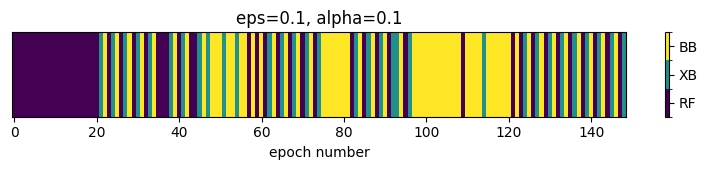

In [43]:
actions = cal.method_samp;
actions = np.array(np.tile(actions[1:], (20,1)));

cmap2 = matplotlib.cm.viridis
cmap2_r = ListedColormap(cmap2.colors[::-1])
bounds = [0, 1, 2, 3]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap2.N)

plt.figure(figsize = (8, 1.8))
plt.imshow(actions, aspect='auto', cmap=cmap2)

plt.xlabel('epoch number')

plt.yticks([])
plt.title(f'eps={eps}, alpha={alpha}')

cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap2),
              orientation='vertical', ticks=[0.5, 1.5, 2.5])

cbar.ax.set_yticklabels(['RF', 'XB', 'BB'])

plt.tight_layout()

(0.0, 1.0)

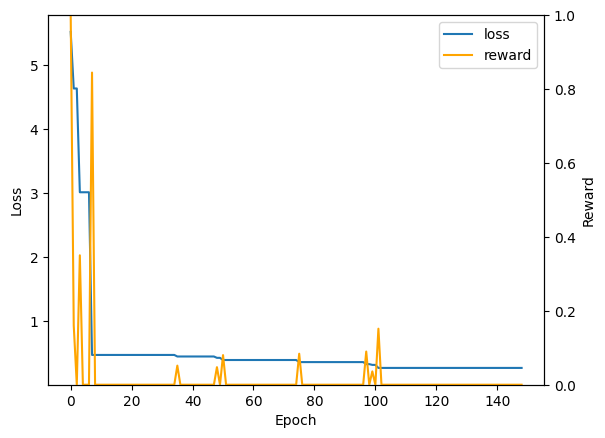

In [49]:
# the convergence of the loss and the reward signals

cum_min = np.minimum.accumulate(cal.losses_samp)
rewards = -((np.roll(cum_min, -1) - cum_min)/cum_min)[:-1]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
lns1 = ax1.plot(cum_min[1:], color="tab:blue", label="loss")
lns2 = ax2.plot(rewards, color="orange", label="reward")

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Reward')

ax2.set_ylim(0.0, 1.0)
